In [4]:
from contextlib import contextmanager
import os
@contextmanager
def cwd(path: str):

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloc
    
    o de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)


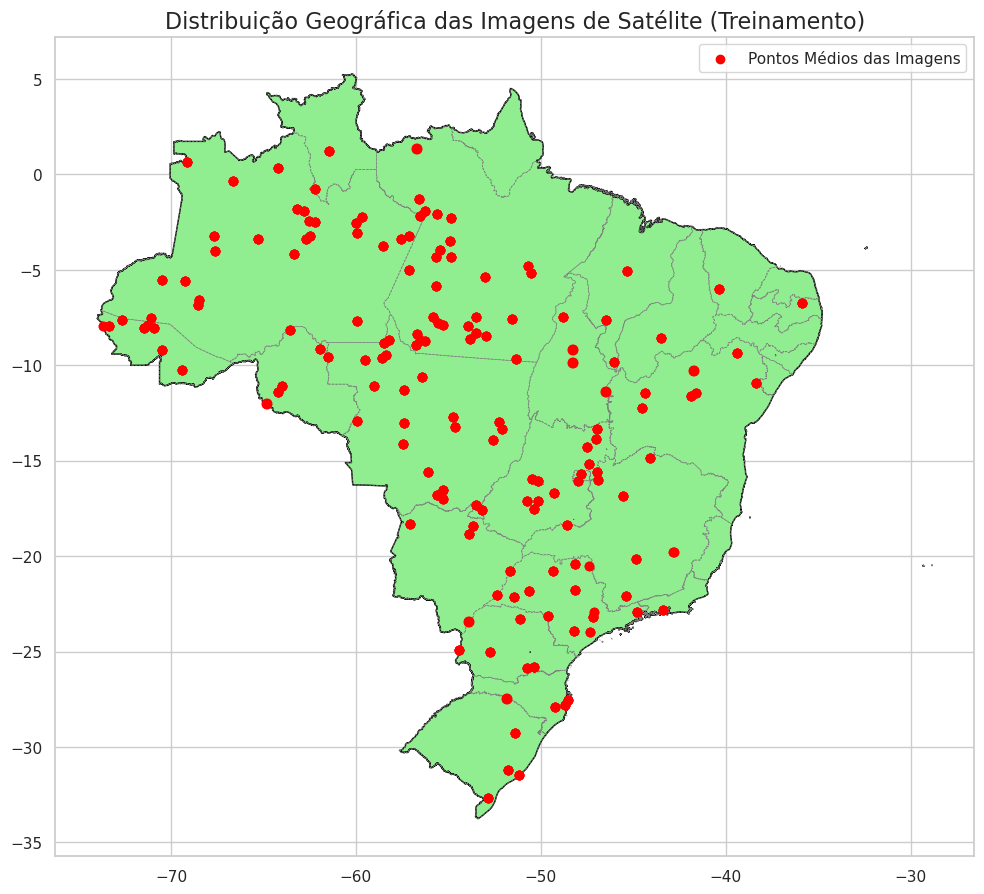

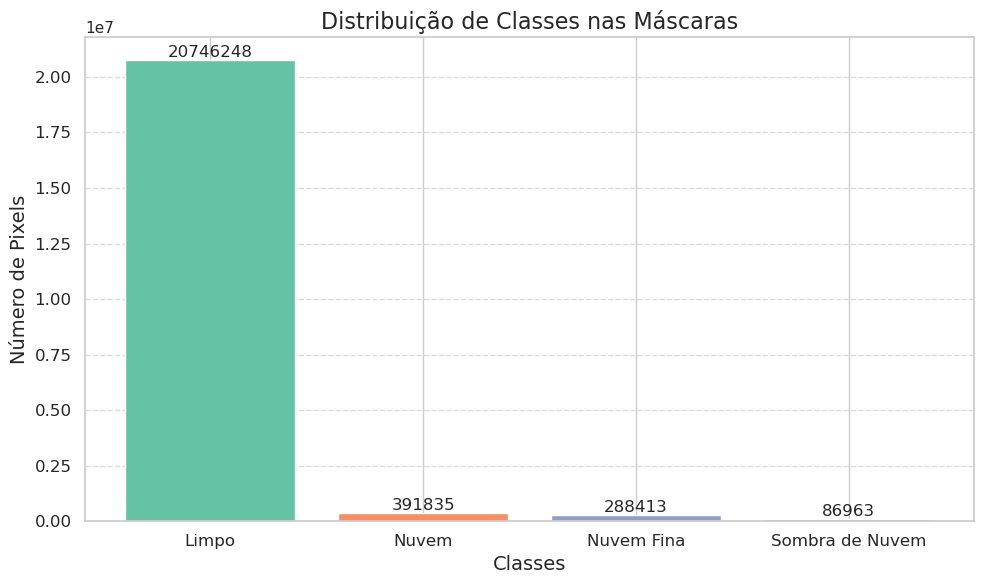

In [25]:
import rasterio
from rasterio.warp import transform_bounds
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns 

# Carregar o shapefile dos limites do Brasil e das divisões estaduais
def load_brazil_boundary():
    brasil = gpd.read_file('BR_Pais_2022/BR_Pais_2022.shp')
    brasil = brasil.to_crs(epsg=4326)  # Garantir que esteja no CRS EPSG:4326
    return brasil

# Carregar o shapefile de estados
def load_states_boundary():
    estados = gpd.read_file('BR_UF_2022/BR_UF_2022.shp')
    estados = estados.to_crs(epsg=4326)
    return estados

# Verificar se uma imagem está dentro dos limites do Brasil e obter o ponto médio
def is_image_within_brazil(image_path, brazil_boundary):
    with rasterio.open(image_path) as src:
        img_crs = src.crs
        bounds = src.bounds
        
        if img_crs.to_string() != 'EPSG:4326':
            bounds = transform_bounds(img_crs, 'EPSG:4326', *bounds)

        img_bbox = box(*bounds)
        centroid = img_bbox.centroid  # Ponto médio da bounding box

        return centroid


def plot_brasil_images_location(caminhos, brazil_boundary, states_boundary):
    # Lista para armazenar as coordenadas centrais das imagens de todos os diretórios
    coordenadas_imagens = []

    # Verificar as imagens e extrair os pontos médios para todos os diretórios
    for src_dir in caminhos:
        for image in os.listdir(src_dir):
            if image.endswith('.tif'):  # Verificar se é um arquivo .tif
                image_path = os.path.join(src_dir, image)
                centro_da_imagem = is_image_within_brazil(image_path, brazil_boundary)
                if centro_da_imagem:
                    coordenadas_imagens.append(centro_da_imagem)

    # Criar o plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotar os limites do Brasil
    brazil_boundary.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=1)

    # Plotar as divisões estaduais
    states_boundary.plot(ax=ax, color='none', edgecolor='gray', linestyle='--', linewidth=0.5)

    # Plotar os pontos médios das imagens de todos os diretórios
    xs = [point.x for point in coordenadas_imagens]
    ys = [point.y for point in coordenadas_imagens]
    ax.scatter(xs, ys, color='red', marker='o', label='Pontos Médios das Imagens')

    # Ajustar o título e a legenda
    ax.set_title('Distribuição Geográfica das Imagens de Satélite (Treinamento)', fontsize=16)
    ax.legend()

    fig.savefig('./graficos/localizacao_imagens.png', bbox_inches='tight', pad_inches=0)
    plt.tight_layout()
    plt.show()

def distribuicao_classes(caminhos):
    # Dicionário para armazenar a contagem de cada classe
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}

    # Percorrer os diretórios
    for src_dir in caminhos:
        for image in os.listdir(src_dir):
            if image.endswith('.tif'):  # Verificar se é um arquivo .tif
                image_path = os.path.join(src_dir, image)
                with rasterio.open(image_path) as raster:
                    if "scribble" in image_path:
                        mask = raster.read(14)  # Ler a banda 14 para scribble
                    else:
                        mask = raster.read(13)  # Ler a banda 13 para os demais

                    unique, counts = np.unique(mask, return_counts=True)
                    for u, c in zip(unique, counts):
                        if u in class_counts:
                            class_counts[u] += c

    # Plotar os resultados
    sns.set_theme(style="whitegrid")

    # Plotar os resultados
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color=sns.color_palette("Set2"))

    # Adicionar anotações
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Número de Pixels', fontsize=14)
    plt.title('Distribuição de Classes nas Máscaras', fontsize=16)
    plt.xticks([0, 1, 2, 3], ['Limpo', 'Nuvem', 'Nuvem Fina', 'Sombra de Nuvem'], fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('./graficos/distribuicao_classes.png', bbox_inches='tight', pad_inches=0)
    plt.show()

    

def main():
    src_dir = r"/home/jean-dias/Documentos/ModelosNuvem/Cloud-Detection-S2-SBSR-main/imagens/CloudSen12_Br_Resized-20240920T225428Z-001/CloudSen12_Br_Resized/p509/high/train_br"  # Diretório de origem
    src_dir_scribble = r"/home/jean-dias/Documentos/ModelosNuvem/Cloud-Detection-S2-SBSR-main/imagens/CloudSen12_Br_Resized-20240920T225428Z-001/CloudSen12_Br_Resized/p509/scribble/train_br"
    src_dir_2000 = r"/home/jean-dias/Documentos/ModelosNuvem/Cloud-Detection-S2-SBSR-main/imagens/CloudSen12_Br_Resized-20240920T225428Z-001/CloudSen12_Br_Resized/p2000/train_br"

    caminhos = [src_dir,src_dir_scribble,src_dir_2000]
    # Carregar os limites do Brasil e estados
    brazil_boundary = load_brazil_boundary()
    states_boundary = load_states_boundary()

    plot_brasil_images_location(caminhos,brazil_boundary,states_boundary)
    distribuicao_classes(caminhos)




if __name__ == '__main__':
    main()